## demonstrate exponential mechanism on release of medians

** Load data and some utility functions

In [1]:
#### Parameters ####

set.seed(1234)
n.sims <- 2000

## Bound/Censor/Clip a variable to a range
clip <- function(x, lower, upper){
	x.clipped <- x
	x.clipped[x.clipped<lower] <- lower
	x.clipped[x.clipped>upper] <- upper
	return(x.clipped)	
}

## Sample with replacement from a vector
bootstrap <- function(x, y=NULL, n){
	index <- sample(x=1:length(x), size=n, replace=TRUE) 

	if(is.null(y)){
		return(x[index])
	}else{
		return(list(x=x[index], y=y[index]))
	}
}

## Load the data

library("foreign")
PUMSdata <- read.csv(file="https://raw.githubusercontent.com/privacytoolsproject/cs208/master/data/FultonPUMS5full.csv")   
data <- PUMSdata$educ    		# variable for means
populationTrue <- median(data)


**Here is our Exponential Mechanism for Median Release

In [2]:
medianRelease <- function(x, lower, upper, nbins=0, epsilon){
	n <- length(x)
	if(nbins==0){
		bins <- floor(lower):ceiling(upper)    # For integers, this is just lower:upper
        nbins <- length(bins)
    }
	x.clipped <- clip(x, lower, upper)
    sensitiveValue <- median(x)

	quality <- rep(NA, nbins)
	for(i in 1:length(quality)){
		quality[i] <- quality[i] <- min( sum(x.clipped<=bins[i]), sum(x.clipped>=bins[i]) )  # This is the missing piece developed in lecture
	}
	likelihoods <- exp(epsilon * quality) / 2
	probabilities <- likelihoods/sum(likelihoods)
    
    flag <- runif(n=1, min=0, max=1) < cumsum(probabilities) # See also rmultinom()
    DPrelease <- min(bins[flag]) 

    return(list(release=DPrelease, true=sensitiveValue))
}


**Show repeated releases on one sample of data

pdf 
  2

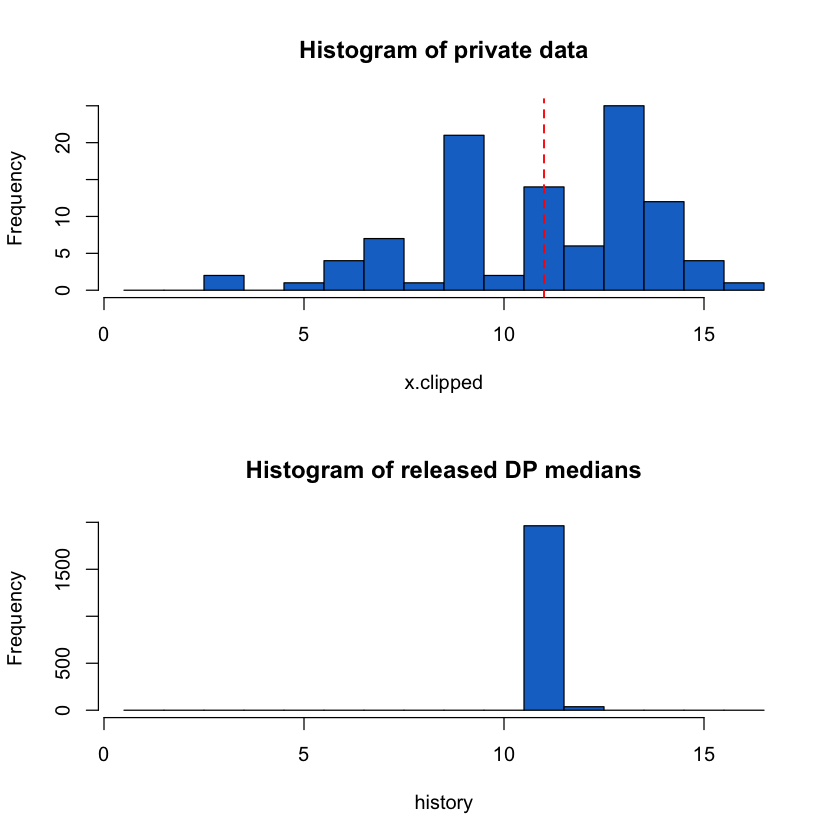

In [3]:
sample.index <- sample(1:length(data), size=100, replace=FALSE)
x <- data[sample.index]

history <- rep(NA, n.sims)
for(i in 1:n.sims){
	history[i] <- medianRelease(x=x, lower=1, upper=16, epsilon=1)$release
}

par(mfcol=c(2,1))
x.clipped <- clip(x, lower=1, upper=16)
hist(x.clipped, breaks=(1:17 -0.5), col="dodgerblue3", main="Histogram of private data")
abline(v=median(x.clipped), col="red", lwd=1.5, lty=2)
dev.copy2pdf(file="./figs/medianExampleDataDist.pdf")

hist(history, breaks=(1:17 -0.5), col="dodgerblue3", main="Histogram of released DP medians")


**Simulate the exponential mechanism across bootstrapped datasets to see utility									

In [4]:
my.seq <- seq(from=log10(50), to=log10(1000), length=20)  	# make evenly spaced in logarithmic space
n.seq  <- round(10^my.seq)                                 	# round to integers

my.seq <- seq(from=log10(1), to=log10(0.01), length=5)     	# make evenly spaced in logarithmic space
ep.seq <- round(10^my.seq * 100) /100						# round to two decimal places

rawhistory <- matrix(NA, nrow=length(n.seq)*length(ep.seq)*n.sims, ncol=4)  # matrix to store results
agghistory <- matrix(NA, nrow=length(n.seq)*length(ep.seq), ncol=4)         # matrix to store results
rawcount <- 0												# counter															
aggcount <- 0                                               # counter

for(i in 1:length(n.seq)){
	for(j in 1:length(ep.seq)){
		error <- utility <- NULL
		aggcount <- aggcount + 1
		for(k in 1:n.sims){
			rawcount <- rawcount + 1

			## Median release
			bootdata <- bootstrap(x=data, n=n.seq[i])
			DPmedian <- medianRelease(x=bootdata, lower=1, upper=16, epsilon=ep.seq[j])
			release <- DPmedian$release
			sampleTrue <- DPmedian$true

			error <- c(error, sampleTrue - release)
			utility <- c(utility, min( sum(bootdata<=release), sum(bootdata>=release)) )

			rawhistory[rawcount, 1] <- n.seq[i]
			rawhistory[rawcount, 2] <- ep.seq[j]
			rawhistory[rawcount, 3] <- release
			rawhistory[rawcount, 4] <- sampleTrue

		}
		agghistory[aggcount, 1] <- n.seq[i]
		agghistory[aggcount, 2] <- ep.seq[j]
		agghistory[aggcount, 3] <- sqrt( mean( (error)^2 ) )  # RMSE
		agghistory[aggcount, 4] <- mean(utility/n.seq[i])
	}
}


**Graphs for plotting results in terms of RMSE and utilty

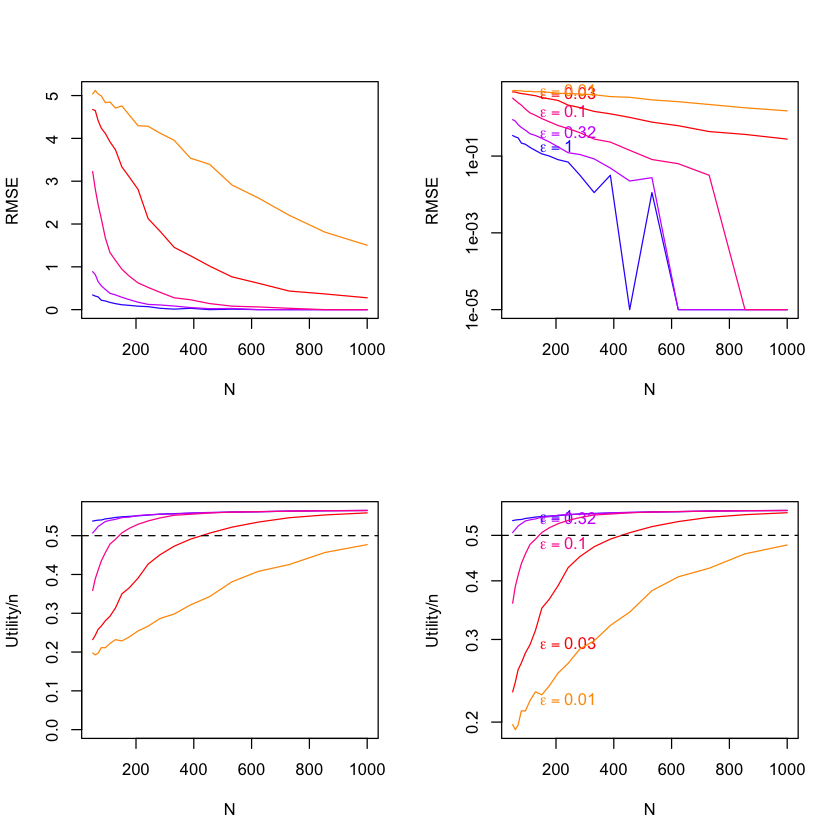

In [5]:
par(mfrow=c(2,2))
color.palette<-rainbow(length(ep.seq), start=.7, end=.1)   # This creates a sequence of colors to use in subsequent plots, as in showchisq.r


for(j in 1:length(ep.seq)){
	flag <- agghistory[,2] == ep.seq[j]
	subhistory <- agghistory[flag,]

	allylim <- c(0, max(agghistory[,3]))

	if(j==1){
		plot(subhistory[,1],subhistory[,3], ylim=allylim, type="l", col=color.palette[j], xlab="N", ylab="RMSE")
	}else{
		lines(subhistory[,1],subhistory[,3], col=color.palette[j])
	}
}

tiny <- .00001
for(j in 1:length(ep.seq)){
	flag <- agghistory[,2] == ep.seq[j]
	subhistory <- agghistory[flag,]

	allylim <- c(min(agghistory[,3])+tiny, max(agghistory[,3]))

	xloc <- round(length(n.seq)*0.3)

	if(j==1){
		plot(subhistory[,1],subhistory[,3]+tiny, ylim=allylim, type="l", log = "y", col=color.palette[j], xlab="N", ylab="RMSE")
		text(x=subhistory[xloc,1], y=subhistory[xloc,3]+tiny, label=  bquote(paste(epsilon == .(ep.seq[j]))), col=color.palette[j], pos=4)
	}else{
		lines(subhistory[,1],subhistory[,3]+tiny, col=color.palette[j])
		text(x=subhistory[xloc,1], y=subhistory[xloc,3]+tiny, label=  bquote(paste(epsilon == .(ep.seq[j]))), col=color.palette[j], pos=4) 
	}
}

for(j in 1:length(ep.seq)){
	flag <- agghistory[,2] == ep.seq[j]
	subhistory <- agghistory[flag,]

	allylim <- c(0, max(agghistory[,4]))

	if(j==1){
		plot(subhistory[,1],subhistory[,4], ylim=allylim, type="l", col=color.palette[j], xlab="N", ylab="Utility/n")
	}else{
		lines(subhistory[,1],subhistory[,4], col=color.palette[j])
	}
}
abline(h=0.5, lty=2)

for(j in 1:length(ep.seq)){
	flag <- agghistory[,2] == ep.seq[j]
	subhistory <- agghistory[flag,]

	allylim <- c(min(agghistory[,4]), max(agghistory[,4]))

	xloc <- round(length(n.seq)*0.3)

	if(j==1){
		plot(subhistory[,1],subhistory[,4], ylim=allylim, type="l", log = "y", col=color.palette[j], xlab="N", ylab="Utility/n")
		text(x=subhistory[xloc,1], y=subhistory[xloc,4], label=  bquote(paste(epsilon == .(ep.seq[j]))), col=color.palette[j], pos=4)
	}else{
		lines(subhistory[,1],subhistory[,4], col=color.palette[j])
		text(x=subhistory[xloc,1], y=subhistory[xloc,4], label=  bquote(paste(epsilon == .(ep.seq[j]))), col=color.palette[j], pos=4) 
	}

}
abline(h=0.5, lty=2)
